# The Robert and Rosenbaum Uncertainty Zones model

# An application to FX Futures in Brazil

## Implementation by
## Marcos Costa Santos Carreira (École Polytechnique - CMAP)
## and
## Florian Huchedé (CME)
## Aug-2019

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [2]:
from pandas.plotting import scatter_matrix

In [3]:
pd.set_option('display.max_columns', 50)

In [4]:
pd.set_option('display.max_rows', 100)

## File paths

In [5]:
PATHPROJ = '/Users/marcoscscarreira/Documents/X/CME project/'
PATHIN = PATHPROJ+'data/'
PATHOUT = PATHPROJ+'dfs/'

## Inputs

#### Parameters

In [6]:
TS = 0.5
START_TIME = pd.to_timedelta('09:00:00')
END_TIME = pd.to_timedelta('18:15:00')
TRADING_HOURS = 9.25

#### File lists

In [7]:
FILESDOL2017 = [
    'DOLG1720170103.csv', 'DOLG1720170104.csv', 'DOLG1720170105.csv', \
    'DOLG1720170106.csv', 'DOLG1720170109.csv', 'DOLG1720170110.csv', \
    'DOLG1720170111.csv', 'DOLG1720170112.csv', 'DOLG1720170113.csv', \
    'DOLG1720170116.csv', 'DOLG1720170117.csv', 'DOLG1720170118.csv', \
    'DOLG1720170119.csv', 'DOLG1720170120.csv', 'DOLG1720170123.csv', \
    'DOLG1720170124.csv', 'DOLG1720170126.csv', 'DOLG1720170127.csv', \
    'DOLG1720170130.csv', 'DOLH1720170131.csv', \
    'DOLH1720170201.csv', 'DOLH1720170202.csv', 'DOLH1720170203.csv', \
    'DOLH1720170207.csv', 'DOLH1720170208.csv', \
    'DOLH1720170209.csv', 'DOLH1720170210.csv', 'DOLH1720170213.csv', \
    'DOLH1720170214.csv', 'DOLH1720170215.csv', 'DOLH1720170216.csv', \
    'DOLH1720170217.csv', 'DOLH1720170220.txt', 'DOLH1720170221.txt', \
    'DOLH1720170222.txt', 'DOLH1720170223.txt']

In [8]:
DATES_DOL = [pd.to_datetime(f[6:14], format='%Y%m%d') for f in FILESDOL2017]
PRODUCT_DOL = [f[:3] for f in FILESDOL2017]
CONTRACT_DOL = [f[3:6] for f in FILESDOL2017]

In [9]:
FILESWDO2017 = [
    'WDOG1720170103.csv', 'WDOG1720170104.csv', 'WDOG1720170105.csv', \
    'WDOG1720170106.csv', 'WDOG1720170109.csv', 'WDOG1720170110.csv', \
    'WDOG1720170111.csv', 'WDOG1720170112.csv', 'WDOG1720170113.csv', \
    'WDOG1720170116.csv', 'WDOG1720170117.csv', 'WDOG1720170118.csv', \
    'WDOG1720170119.csv', 'WDOG1720170120.csv', 'WDOG1720170123.csv', \
    'WDOG1720170124.csv', 'WDOG1720170126.csv', 'WDOG1720170127.csv', \
    'WDOG1720170130.csv', 'WDOH1720170131.csv', \
    'WDOH1720170201.csv', 'WDOH1720170202.csv', 'WDOH1720170203.csv', \
    'WDOH1720170207.csv', 'WDOH1720170208.csv', \
    'WDOH1720170209.csv', 'WDOH1720170210.csv', 'WDOH1720170213.csv', \
    'WDOH1720170214.csv', 'WDOH1720170215.csv', 'WDOH1720170216.csv', \
    'WDOH1720170217.csv', 'WDOH1720170220.txt', 'WDOH1720170221.txt', \
    'WDOH1720170222.txt', 'WDOH1720170223.txt']

In [10]:
DATES_WDO = [pd.to_datetime(f[6:14], format='%Y%m%d') for f in FILESWDO2017]
PRODUCT_WDO = [f[:3] for f in FILESWDO2017]
CONTRACT_WDO = [f[3:6] for f in FILESWDO2017]

## Uncertainty Zones and Top of Book statistics

In [13]:
DF_STATS = pd.DataFrame()
for j in range(len(FILESDOL2017)):
    new_row_1 = pd.read_csv(PATHOUT+FILESDOL2017[j][:-4]+'_OBstats.csv', index_col=0)
    new_row_2 = pd.read_csv(PATHOUT+FILESDOL2017[j][:-4]+'_UZstats.csv', index_col=0)
    new_row = pd.concat([new_row_1, new_row_2], axis=1, sort=False)
    new_row['lambda1'] = pd.read_csv(PATHOUT+FILESDOL2017[j][:-4]+'_CAticks.csv', index_col=0)\
        .set_index('Li').loc[1]['lamb']
    DF_STATS = DF_STATS.append(new_row)
for j in range(len(FILESWDO2017)):
    new_row_1 = pd.read_csv(PATHOUT+FILESWDO2017[j][:-4]+'_OBstats.csv', index_col=0)
    new_row_2 = pd.read_csv(PATHOUT+FILESWDO2017[j][:-4]+'_UZstats.csv', index_col=0)
    new_row = pd.concat([new_row_1, new_row_2], axis=1, sort=False)
    new_row['lambda1'] = pd.read_csv(PATHOUT+FILESWDO2017[j][:-4]+'_CAticks.csv', index_col=0)\
        .set_index('Li').loc[1]['lamb']
    DF_STATS = DF_STATS.append(new_row)
DF_STATS['Dates'] = DATES_DOL+DATES_WDO
DF_STATS['Product'] = PRODUCT_DOL+PRODUCT_WDO
DF_STATS['Contract'] = CONTRACT_DOL+CONTRACT_WDO
DF_STATS.set_index(['Product', 'Contract', 'Dates'], inplace=True)
DF_STATS.sort_index(inplace=True)
DF_STATS['ndfpr_pred'] = TRADING_HOURS*3600/DF_STATS['duration']
#DF_STATS['ndfpr_pred'] = ((DF_STATS['rvx']*DF_STATS['spot_avg']/TS)**2)/(2*DF_STATS['eta1'])
DF_STATS['eta*alpha*sqrt(M)'] = DF_STATS['eta1']*TS*np.sqrt(DF_STATS['M'])
DF_STATS['S*sqrt(M)'] = DF_STATS['twspr1']*TS*np.sqrt(DF_STATS['M'])
DF_STATS['sigma'] = DF_STATS['rvx']*DF_STATS['spot_avg']
DF_STATS['p1*eta*alpha*sqrt(M)'] = np.where(DF_STATS.reset_index()['Product']=='DOL', 1.2119, 1.9221)*DF_STATS['eta*alpha*sqrt(M)']
DF_STATS['sigma-p2*S*sqrt(M)'] = DF_STATS['sigma']-\
    np.where(DF_STATS.reset_index()['Product']=='DOL', 0.0870, 0.0364)*DF_STATS['S*sqrt(M)']

In [14]:
DF_STATS_PLOT = DF_STATS.copy().reset_index()

In [13]:
#DF_STATS

## Tables

### Table 1

In [17]:
DF_STATS[['chgavg', 'ndfpr_pred', 'ndfpr', 'M', 'eta1',\
    'S1', 'lambda1', 'twspr1', 'duration', 'dt_avg', 'rvxe', 'spot_avg']]\
    .groupby('Product').mean()

,chgavg,ndfpr_pred,ndfpr,M,eta1,S1,lambda1,twspr1,duration,dt_avg,rvxe,spot_avg
Product,,,,,,,,,,,,
DOL,0.515071,4034.988569,3663.055556,11715.944444,0.279884,0.942521,0.972351,1.157918,8.993508,9.838828,0.007434,3166.775373
WDO,0.509309,16766.321405,15769.694444,55858.055556,0.081605,0.971864,0.983815,1.028888,2.102894,2.230766,0.008222,3166.984556


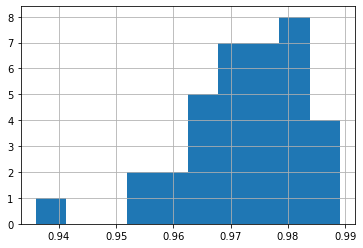

In [18]:
DF_STATS.loc['DOL']['lambda1'].hist();

## Charts

In [19]:
def lin_reg(data, independent, dependent, logdata=False):
    X = data[independent]
    Y = data[dependent]
    if logdata:
        X = np.log(X)
        Y = np.log(Y)
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) 
    print_model = model.summary()
    print(print_model)

In [20]:
def lin_reg_sa(x, y, logdata=False):
    X = x
    Y = y
    if logdata:
        X = np.log(X)
        Y = np.log(Y)
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) 
    print_model = model.summary()
    print(print_model)

In [21]:
def log_df(data, dependent, independent, hue):
    return pd.concat([np.log(data[dependent]), np.log(data[independent]), data[hue]], axis=1)

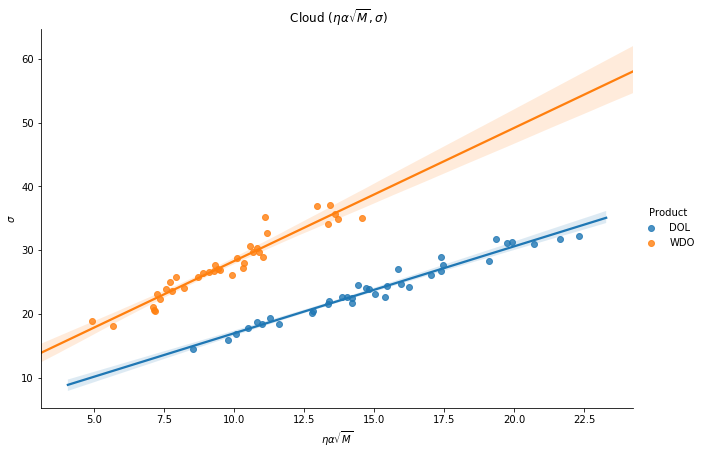

In [22]:
sns.lmplot(x='eta*alpha*sqrt(M)', y='sigma', hue='Product', data=DF_STATS_PLOT,\
          height=6, aspect=1.5);
plt.title(r' Cloud ('
          r'$\eta\alpha\sqrt{M}, \sigma)$');
plt.xlabel(r'$\eta\alpha\sqrt{M}$');
plt.ylabel(r'$\sigma$');

In [23]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['eta*alpha*sqrt(M)', 'S*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     589.3
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           1.51e-26
Time:                        18:51:24   Log-Likelihood:                -42.629
No. Observations:                  36   AIC:                             91.26
Df Residuals:                      33   BIC:                             96.01
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2230      1.08

/Users/marcoscscarreira/anaconda3/envs/CondaEnv36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['eta*alpha*sqrt(M)', 'S*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     189.1
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           8.38e-19
Time:                        18:51:25   Log-Likelihood:                -63.997
No. Observations:                  36   AIC:                             134.0
Df Residuals:                      33   BIC:                             138.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.6316      2.90

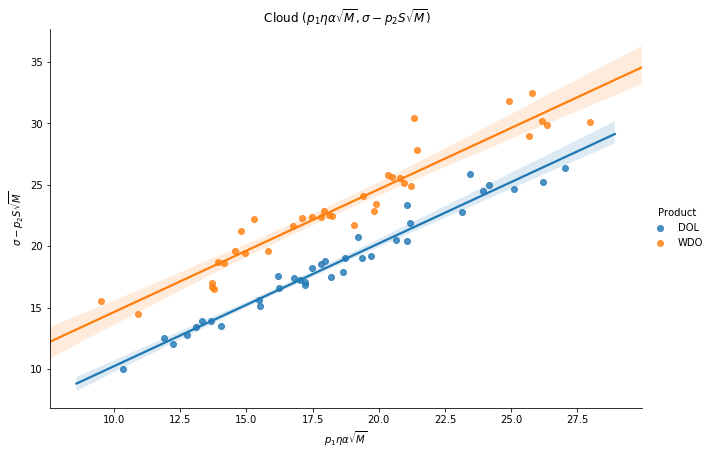

In [25]:
sns.lmplot(x='p1*eta*alpha*sqrt(M)', y='sigma-p2*S*sqrt(M)', hue='Product', data=DF_STATS_PLOT,\
          height=6, aspect=1.5);
plt.title(r' Cloud ('
          r'$p_{1}\eta\alpha\sqrt{M}, \sigma-p_{2}S\sqrt{M})$');
plt.xlabel(r'$p_{1}\eta\alpha\sqrt{M}$');
plt.ylabel(r'$\sigma-p_{2}S\sqrt{M}$');

In [26]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['p1*eta*alpha*sqrt(M)'], 'sigma-p2*S*sqrt(M)')

                            OLS Regression Results                            
Dep. Variable:     sigma-p2*S*sqrt(M)   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     951.3
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           1.93e-26
Time:                        18:51:27   Log-Likelihood:                -42.629
No. Observations:                  36   AIC:                             89.26
Df Residuals:                      34   BIC:                             92.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2242 

In [27]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['p1*eta*alpha*sqrt(M)'], 'sigma-p2*S*sqrt(M)')

                            OLS Regression Results                            
Dep. Variable:     sigma-p2*S*sqrt(M)   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     329.9
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           4.48e-19
Time:                        18:51:27   Log-Likelihood:                -63.997
No. Observations:                  36   AIC:                             132.0
Df Residuals:                      34   BIC:                             135.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.6339 

In [28]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['eta*alpha*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     869.2
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           8.46e-26
Time:                        18:51:28   Log-Likelihood:                -48.454
No. Observations:                  36   AIC:                             100.9
Df Residuals:                      34   BIC:                             104.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.3790      0.71

In [29]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['eta*alpha*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     376.2
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           5.83e-20
Time:                        18:51:30   Log-Likelihood:                -64.581
No. Observations:                  36   AIC:                             133.2
Df Residuals:                      34   BIC:                             136.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.4486      1.07

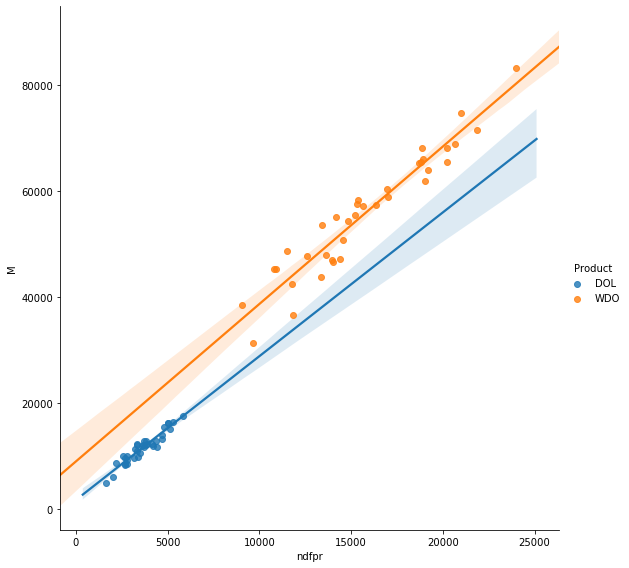

In [30]:
sns.lmplot(x='ndfpr', y='M', hue='Product', aspect=1, \
            height=8, data=DF_STATS_PLOT);

In [31]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], 'ndfpr', 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     317.9
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           7.95e-19
Time:                        18:51:56   Log-Likelihood:                -294.64
No. Observations:                  36   AIC:                             593.3
Df Residuals:                      34   BIC:                             596.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1787.1468    576.416      3.100      0.0

In [32]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], 'ndfpr', 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     371.8
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           7.00e-20
Time:                        18:51:57   Log-Likelihood:                -342.48
No. Observations:                  36   AIC:                             689.0
Df Residuals:                      34   BIC:                             692.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9050.8744   2491.722      3.632      0.0

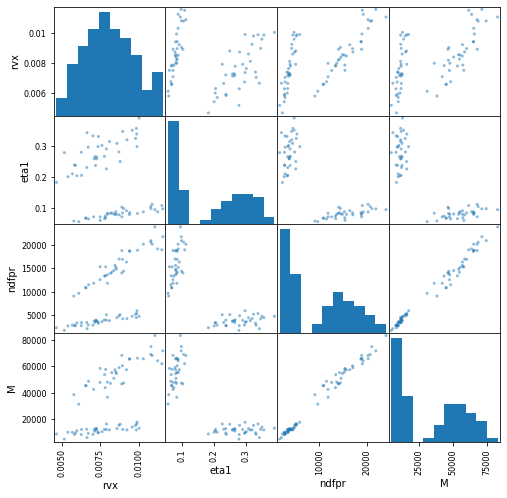

In [33]:
scatter_matrix(DF_STATS_PLOT[['rvx','eta1','ndfpr','M']], figsize=(8, 8));

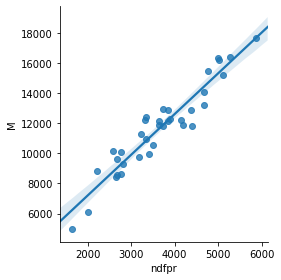

In [34]:
sns.lmplot(x='ndfpr', y='M', aspect=1, \
            height=4, data=DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL']);

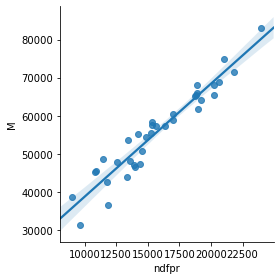

In [35]:
sns.lmplot(x='ndfpr', y='M', aspect=1, \
            height=4, data=DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO']);

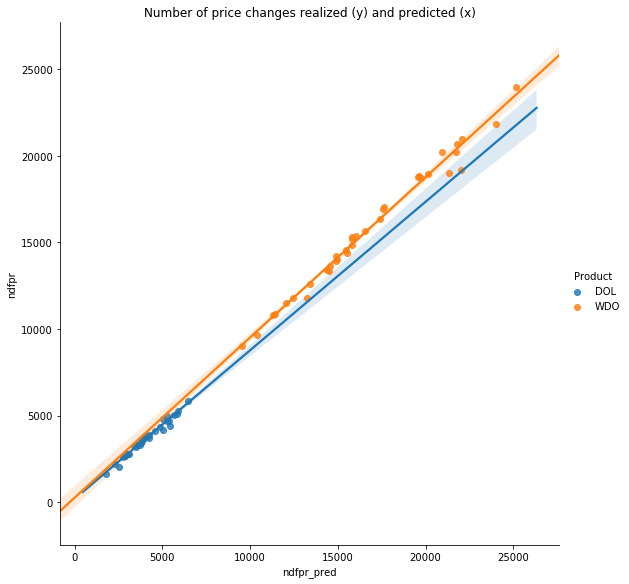

In [36]:
sns.lmplot(x='ndfpr_pred', y='ndfpr', hue='Product', aspect=1, \
            height=8, data=DF_STATS_PLOT);
plt.title('Number of price changes realized (y) and predicted (x)');

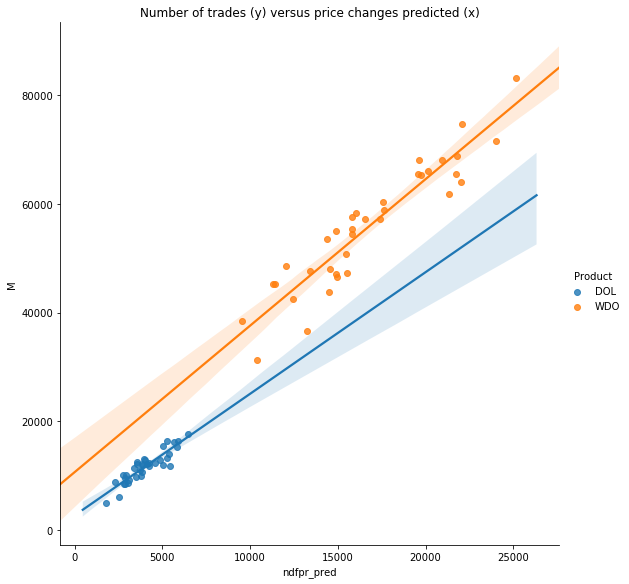

In [39]:
sns.lmplot(x='ndfpr_pred', y='M', hue='Product', aspect=1, \
            height=8, data=DF_STATS_PLOT);
plt.title('Number of trades (y) versus price changes predicted (x)');

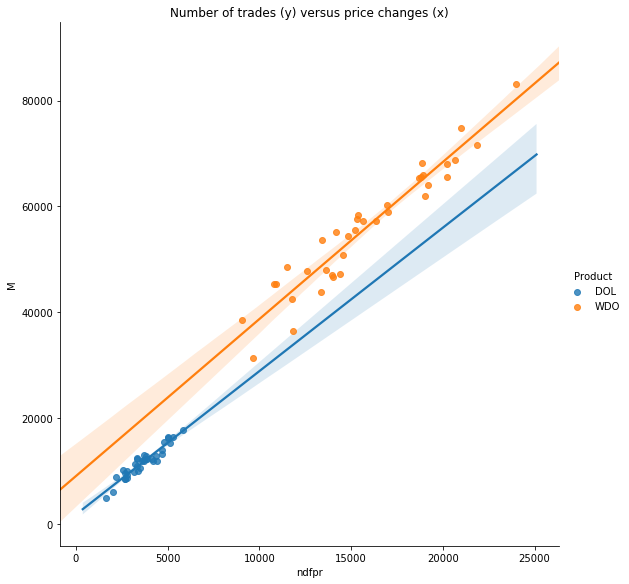

In [40]:
sns.lmplot(x='ndfpr', y='M', hue='Product', aspect=1, \
            height=8, data=DF_STATS_PLOT);
plt.title('Number of trades (y) versus price changes (x)');

In [37]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['ndfpr_pred'], 'ndfpr')

                            OLS Regression Results                            
Dep. Variable:                  ndfpr   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1405.
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           3.06e-29
Time:                        18:53:14   Log-Likelihood:                -231.56
No. Observations:                  36   AIC:                             467.1
Df Residuals:                      34   BIC:                             470.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.7434     95.773      2.148      0.0

In [38]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['ndfpr_pred'], 'ndfpr')

                            OLS Regression Results                            
Dep. Variable:                  ndfpr   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2616.
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           9.43e-34
Time:                        18:53:16   Log-Likelihood:                -267.96
No. Observations:                  36   AIC:                             539.9
Df Residuals:                      34   BIC:                             543.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        266.1894    311.275      0.855      0.3

In [41]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['ndfpr'], 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     317.9
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           7.95e-19
Time:                        18:56:06   Log-Likelihood:                -294.64
No. Observations:                  36   AIC:                             593.3
Df Residuals:                      34   BIC:                             596.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1787.1468    576.416      3.100      0.0

In [42]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['ndfpr'], 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     371.8
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           7.00e-20
Time:                        18:56:07   Log-Likelihood:                -342.48
No. Observations:                  36   AIC:                             689.0
Df Residuals:                      34   BIC:                             692.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9050.8744   2491.722      3.632      0.0

In [40]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['ndfpr_pred'], 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     141.7
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           1.13e-13
Time:                        13:10:25   Log-Likelihood:                -307.15
No. Observations:                  36   AIC:                             618.3
Df Residuals:                      34   BIC:                             621.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2740.2184    782.954      3.500      0.0

In [41]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['ndfpr_pred'], 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     98.42
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           1.43e-11
Time:                        13:10:26   Log-Likelihood:                -362.64
No. Observations:                  36   AIC:                             729.3
Df Residuals:                      34   BIC:                             732.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.363e+04   4368.783      3.120      0.0

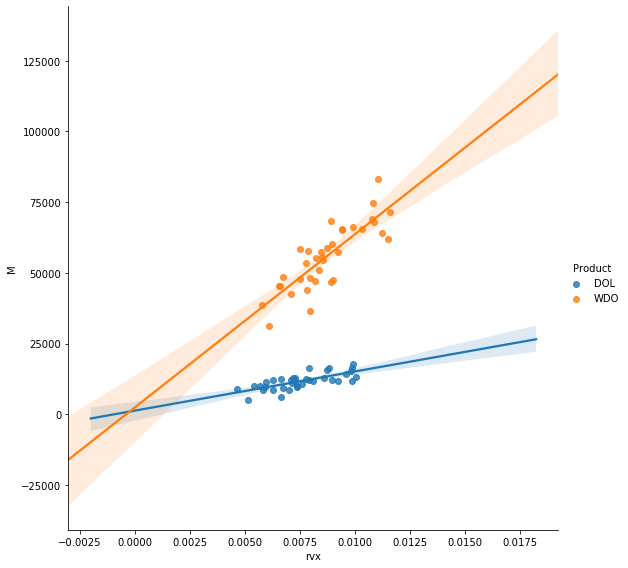

In [42]:
sns.lmplot(x='rvx', y='M', hue='Product', aspect=1, \
            height=8, data=DF_STATS_PLOT);

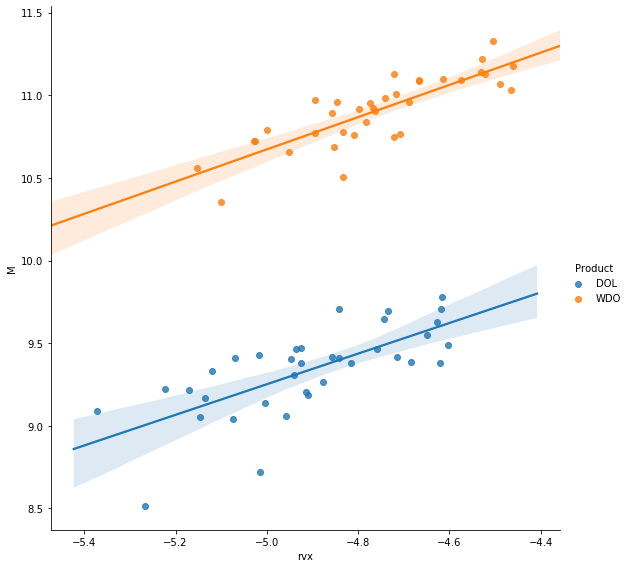

In [43]:
sns.lmplot(x='rvx', y='M', hue='Product', aspect=1, \
            height=8, data=log_df(DF_STATS_PLOT, 'rvx', 'M', 'Product'));

In [44]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['rvx'], 'ndfpr', True)

                            OLS Regression Results                            
Dep. Variable:                  ndfpr   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     119.7
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           1.11e-12
Time:                        13:10:27   Log-Likelihood:                 21.436
No. Observations:                  36   AIC:                            -38.87
Df Residuals:                      34   BIC:                            -35.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3164      0.562     25.455      0.0

In [45]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['rvx'], 'M', True)

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     34.51
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           1.25e-06
Time:                        13:10:27   Log-Likelihood:                 9.9250
No. Observations:                  36   AIC:                            -15.85
Df Residuals:                      34   BIC:                            -12.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.8823      0.774     17.928      0.0

In [46]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['rvx'], 'ndfpr', True)

                            OLS Regression Results                            
Dep. Variable:                  ndfpr   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     277.3
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           6.41e-18
Time:                        13:10:29   Log-Likelihood:                 40.492
No. Observations:                  36   AIC:                            -76.98
Df Residuals:                      34   BIC:                            -73.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6132      0.359     43.486      0.0

In [47]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['rvx'], 'M', True)

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     73.97
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           4.77e-10
Time:                        13:10:30   Log-Likelihood:                 25.801
No. Observations:                  36   AIC:                            -47.60
Df Residuals:                      34   BIC:                            -44.44
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5500      0.540     28.797      0.0

In [48]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['eta1', 'rvx'], 'M', True)

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     223.3
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           6.61e-20
Time:                        13:10:31   Log-Likelihood:                 45.490
No. Observations:                  36   AIC:                            -84.98
Df Residuals:                      33   BIC:                            -80.23
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6430      0.350     47.490      0.0

In [49]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['eta1', 'rvx'], 'M', True)

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     55.16
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           2.99e-11
Time:                        13:10:32   Log-Likelihood:                 31.437
No. Observations:                  36   AIC:                            -56.87
Df Residuals:                      33   BIC:                            -52.12
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5597      0.551     30.050      0.0

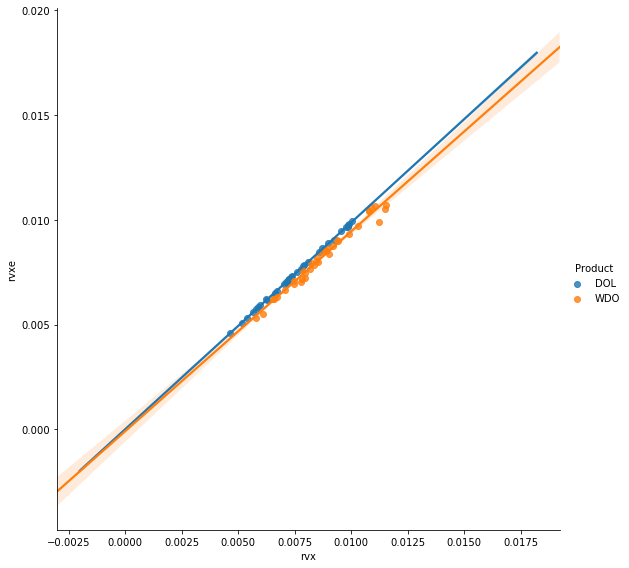

In [50]:
sns.lmplot(x='rvx', y='rvxe', hue='Product', aspect=1, \
            height=8, data=DF_STATS_PLOT);

In [51]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL'], ['rvx'], 'rvxe', True)

                            OLS Regression Results                            
Dep. Variable:                   rvxe   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.341e+04
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           2.11e-54
Time:                        13:10:33   Log-Likelihood:                 135.62
No. Observations:                  36   AIC:                            -267.2
Df Residuals:                      34   BIC:                            -264.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0125      0.024     -0.530      0.6

In [52]:
lin_reg(DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO'], ['rvx'], 'rvxe', True)

                            OLS Regression Results                            
Dep. Variable:                   rvxe   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     2109.
Date:                Mon, 19 Aug 2019   Prob (F-statistic):           3.51e-32
Time:                        13:10:34   Log-Likelihood:                 84.285
No. Observations:                  36   AIC:                            -164.6
Df Residuals:                      34   BIC:                            -161.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0638      0.106      0.600      0.5

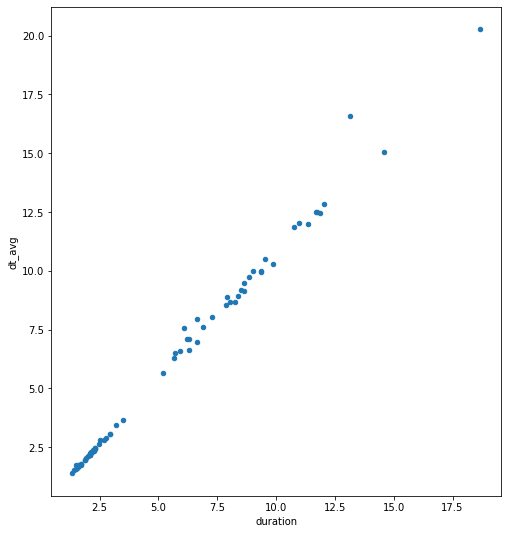

In [53]:
ax = DF_STATS.plot.scatter(x='duration', y='dt_avg', figsize=(9,9));
ax.set_aspect('equal')

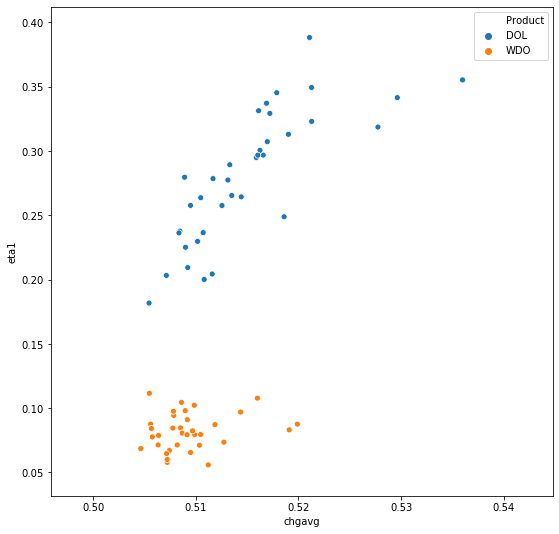

In [54]:
plt.figure(figsize=(9,9))
sns.scatterplot(x='chgavg', y='eta1', hue='Product',\
            data=DF_STATS_PLOT);

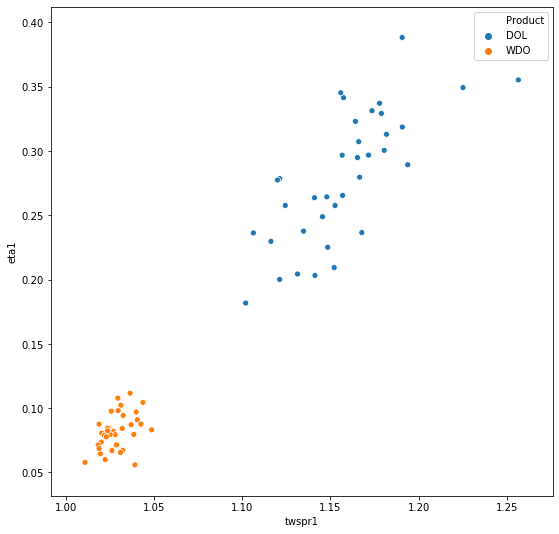

In [55]:
plt.figure(figsize=(9,9))
sns.scatterplot(x='twspr1', y='eta1', hue='Product',\
            data=DF_STATS_PLOT);

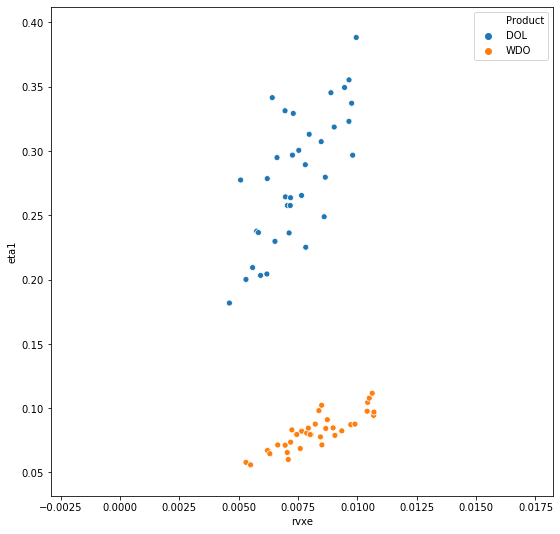

In [56]:
plt.figure(figsize=(9,9))
sns.scatterplot(x='rvxe', y='eta1', hue='Product',\
            data=DF_STATS_PLOT);

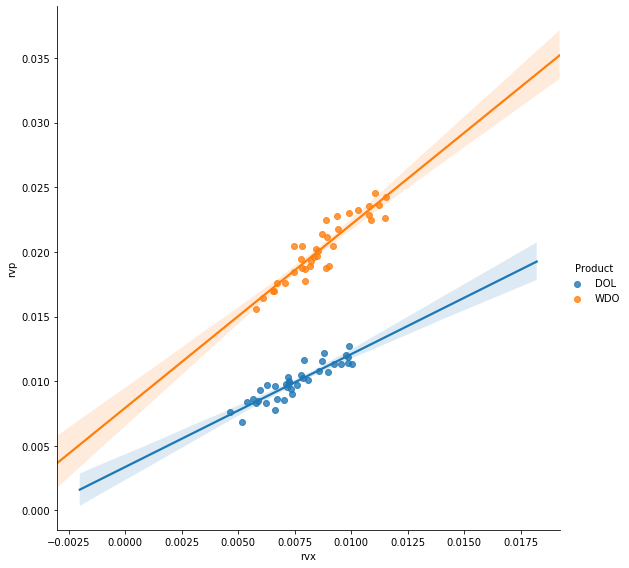

In [57]:
sns.lmplot(x='rvx', y='rvp', hue='Product', aspect=1, \
            height=8, data=DF_STATS_PLOT);

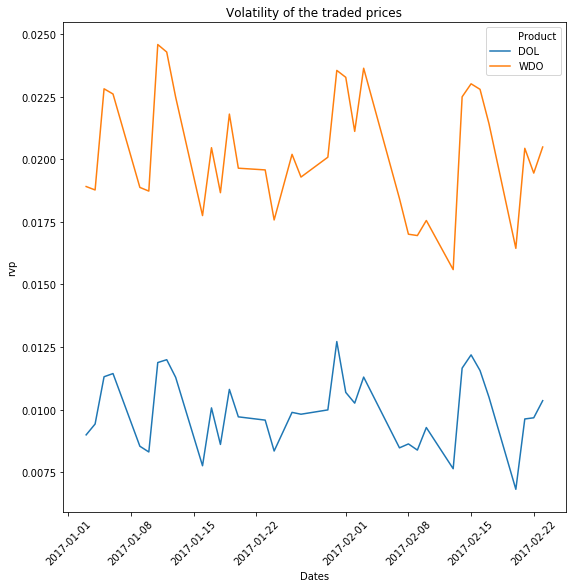

In [58]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='rvp', hue='Product', data=DF_STATS_PLOT);
plt.xticks(rotation=45);
plt.title('Volatility of the traded prices');

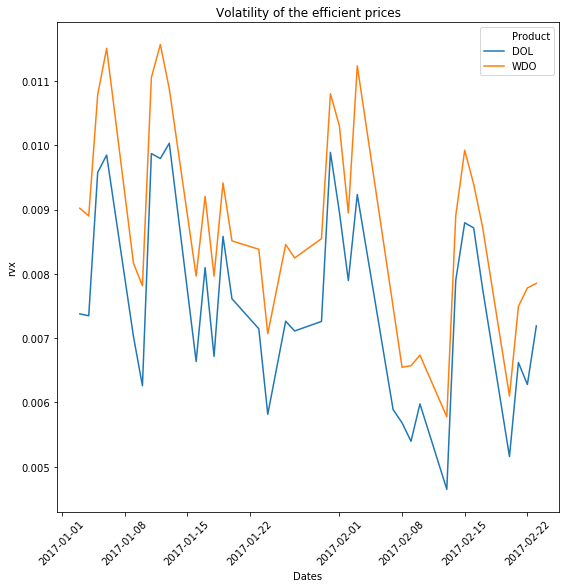

In [59]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='rvx', hue='Product', data=DF_STATS_PLOT);
plt.xticks(rotation=45);
plt.title('Volatility of the efficient prices');

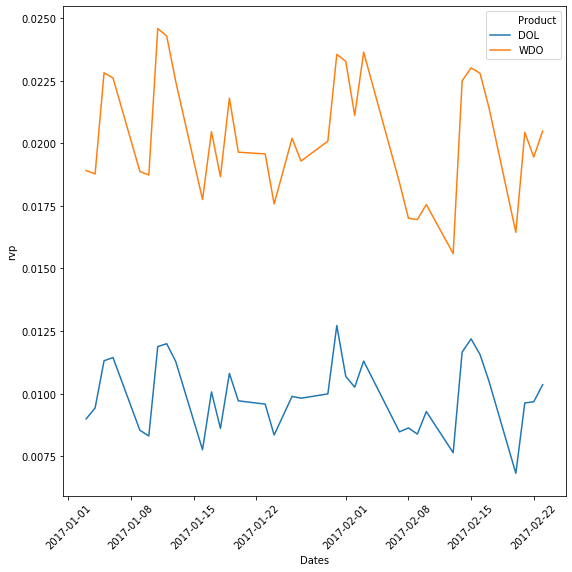

In [60]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='rvp', hue='Product', data=DF_STATS_PLOT);
plt.xticks(rotation=45);

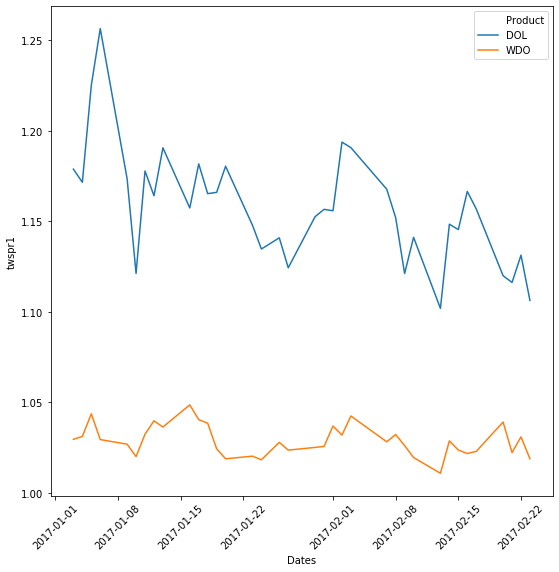

In [61]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='twspr1', hue='Product', data=DF_STATS_PLOT);
plt.xticks(rotation=45);

## States - Orders and Trades

In [17]:
DF_STATS_IMBAL = pd.DataFrame()
for j in range(len(FILESDOL2017)):
    new_row = pd.read_csv(PATHOUT+FILESDOL2017[j][:-4]+'_OTtrans.csv', index_col=0)
    new_row['Dates'] = DATES_DOL[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESDOL2017[j][:3]
    new_row['Contract'] = FILESDOL2017[j][3:6]
    DF_STATS_IMBAL = DF_STATS_IMBAL.append(new_row)
for j in range(len(FILESWDO2017)):
    new_row = pd.read_csv(PATHOUT+FILESWDO2017[j][:-4]+'_OTtrans.csv', index_col=0)
    new_row['Dates'] = DATES_WDO[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESWDO2017[j][:3]
    new_row['Contract'] = FILESWDO2017[j][3:6]
    DF_STATS_IMBAL = DF_STATS_IMBAL.append(new_row)
DF_STATS_IMBAL.reset_index()
DF_STATS_IMBAL.set_index(['Product', 'Contract', 'Dates'], inplace=True)
DF_STATS_IMBAL.sort_index(inplace=True)

In [18]:
def get_imbal_mat(product, date):
    mat_values = DF_STATS_IMBAL.loc[product, :, date].values
    mat_df = pd.DataFrame(mat_values,\
        columns=['Trade_Bid', 'Imbal_Bid',\
            'Neutral', 'Imbal_Ask', 'Trade_Ask'],\
        index=['Trade_Bid', 'Imbal_Bid',\
            'Neutral', 'Imbal_Ask', 'Trade_Ask'])
    return mat_df

In [19]:
def perc_mat(mat):
    sum_mat = mat.to_numpy().sum()
    norm_mat = (100*mat/sum_mat)
    norm_mat['Total Cols'] = norm_mat.sum(axis=1)
    norm_mat.loc['Total Rows'] = norm_mat.sum(axis=0)
    return norm_mat

In [20]:
def perc_mat_r(mat, dec=2):
    sum_mat = mat.to_numpy().sum()
    norm_mat = (100*mat/sum_mat)
    norm_mat['Total Cols'] = norm_mat.sum(axis=1)
    norm_mat.loc['Total Rows'] = norm_mat.sum(axis=0)
    return norm_mat.round(dec)

In [21]:
IMBAL_DATES = DF_STATS_IMBAL.index.get_level_values('Dates').unique().values

In [22]:
def avg_perc_mat(product, dates):
    date_count = 1
    result = perc_mat(get_imbal_mat(product, dates[date_count-1]))
    for date in dates[1:]:
        date_count += 1
        result += (perc_mat(get_imbal_mat(product, dates[date_count-1]))-result)/date_count
    return result

In [23]:
def summ_imbal(mat):
    pred_ib = (mat.loc['Imbal_Bid']['Trade_Bid']-mat.loc['Imbal_Bid']['Trade_Ask'])
    pred_ia = (mat.loc['Imbal_Ask']['Trade_Ask']-mat.loc['Imbal_Ask']['Trade_Bid'])
    pred_imb = (pred_ib+pred_ia)/2
    pred_ibr = pred_ib/mat.loc['Imbal_Bid']['Total Cols']*100
    pred_iar = pred_ia/mat.loc['Imbal_Ask']['Total Cols']*100
    pred_imbr = (pred_ibr+pred_iar)/2
    return [pred_imb, pred_imbr]

In [24]:
def time_series_imbal(product, dates):
    list_imbal = []
    for date in dates:
        new_mat = perc_mat(get_imbal_mat(product, date))
        new_row = summ_imbal(new_mat)
        list_imbal = list_imbal+[new_row]
    df_imbal = pd.DataFrame(list_imbal, columns=['Pred_Imbal', 'Pred_Imbal_Relat'],\
            index=dates)
    return df_imbal

In [25]:
def summ_trade(mat):
    pred_tb = (mat.loc['Trade_Bid']['Trade_Bid']-mat.loc['Trade_Bid']['Trade_Ask'])
    pred_ta = (mat.loc['Trade_Ask']['Trade_Ask']-mat.loc['Trade_Ask']['Trade_Bid'])
    pred_trd = (pred_tb+pred_ta)/2
    pred_tbr = pred_tb/mat.loc['Trade_Bid']['Total Cols']*100
    pred_tar = pred_ta/mat.loc['Trade_Ask']['Total Cols']*100
    pred_trdr = (pred_tbr+pred_tar)/2
    return [pred_trd, pred_trdr]

In [26]:
def time_series_imbal_trd(product, dates):
    list_imbal = []
    for date in dates:
        new_mat = perc_mat(get_imbal_mat(product, date))
        new_row = summ_trade(new_mat)
        list_imbal = list_imbal+[new_row]
    df_imbal = pd.DataFrame(list_imbal, columns=['Pred_Trade', 'Pred_Trade_Relat'],\
            index=dates)
    return df_imbal

In [27]:
DOL_ETA = DF_STATS_PLOT[DF_STATS_PLOT['Product']=='DOL']['eta1'].values

In [92]:
DOL_IMBAL_TS = pd.concat([time_series_imbal('DOL', IMBAL_DATES),\
                         time_series_imbal_trd('DOL', IMBAL_DATES)], axis=1, sort=False)

In [93]:
DOL_IMBAL_TS['eta1'] = DOL_ETA
DOL_IMBAL_TS['Product'] = 'DOL'
DOL_IMBAL_TS.index.names=['Dates']

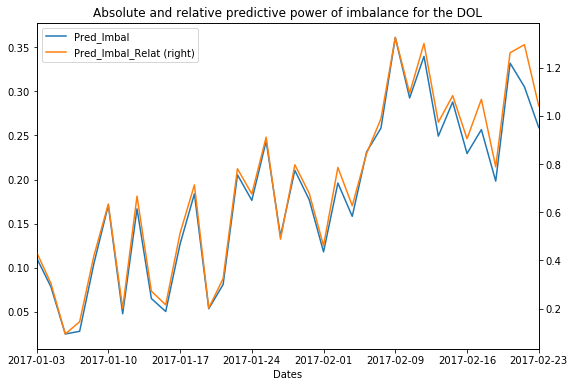

In [30]:
DOL_IMBAL_TS[['Pred_Imbal', 'Pred_Imbal_Relat']].plot(secondary_y=['Pred_Imbal_Relat'],\
    figsize=(9,6), title='Absolute and relative predictive power of imbalance for the DOL');

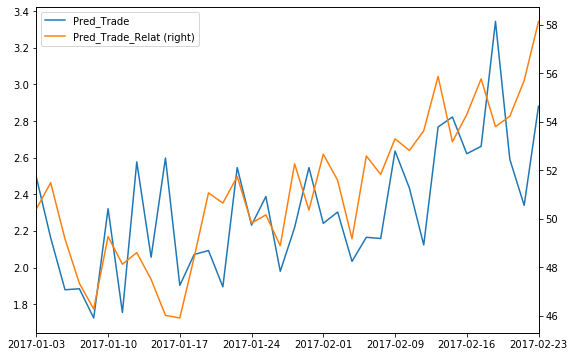

In [117]:
DOL_IMBAL_TS[['Pred_Trade', 'Pred_Trade_Relat']].plot(secondary_y=['Pred_Trade_Relat'], figsize=(9,6));

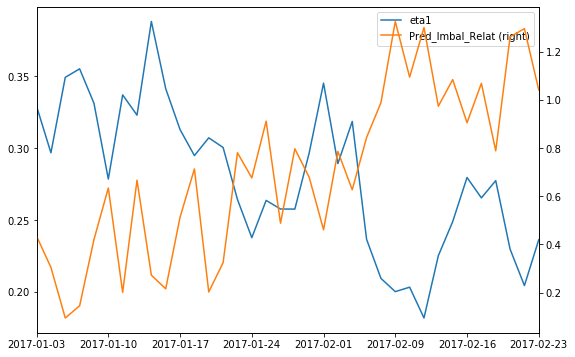

In [118]:
DOL_IMBAL_TS[['eta1', 'Pred_Imbal_Relat']].plot(secondary_y=['Pred_Imbal_Relat'], figsize=(9,6));

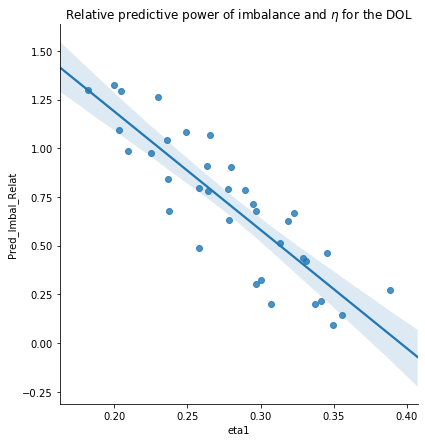

In [38]:
sns.lmplot(x='eta1', y='Pred_Imbal_Relat', data=DOL_IMBAL_TS,\
           aspect=1, height=6);
plt.title('Relative predictive power of imbalance and $\eta$ for the DOL');

In [31]:
WDO_ETA = DF_STATS_PLOT[DF_STATS_PLOT['Product']=='WDO']['eta1'].values

In [90]:
WDO_IMBAL_TS = pd.concat([time_series_imbal('WDO', IMBAL_DATES),\
                         time_series_imbal_trd('WDO', IMBAL_DATES)], axis=1, sort=False)

In [91]:
WDO_IMBAL_TS['eta1'] = WDO_ETA
WDO_IMBAL_TS['Product'] = 'WDO'
WDO_IMBAL_TS.index.names=['Dates']

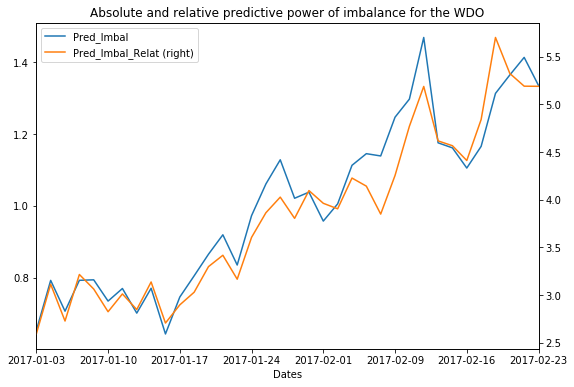

In [34]:
WDO_IMBAL_TS[['Pred_Imbal', 'Pred_Imbal_Relat']].plot(secondary_y=['Pred_Imbal_Relat'],\
    figsize=(9,6), title='Absolute and relative predictive power of imbalance for the WDO');

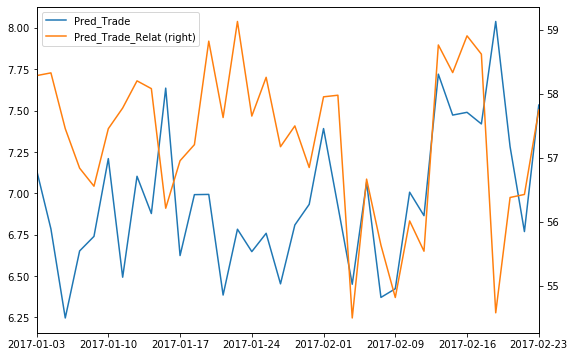

In [127]:
WDO_IMBAL_TS[['Pred_Trade', 'Pred_Trade_Relat']].plot(secondary_y=['Pred_Trade_Relat'], figsize=(9,6));

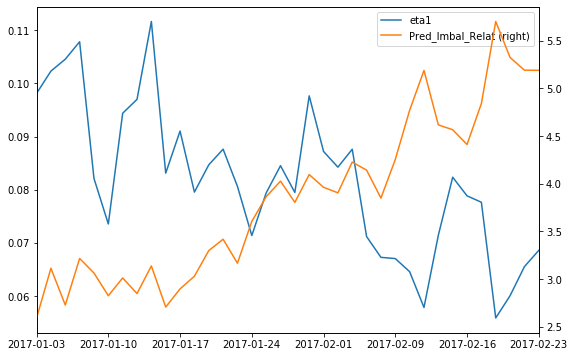

In [128]:
WDO_IMBAL_TS[['eta1', 'Pred_Imbal_Relat']].plot(secondary_y=['Pred_Imbal_Relat'], figsize=(9,6));

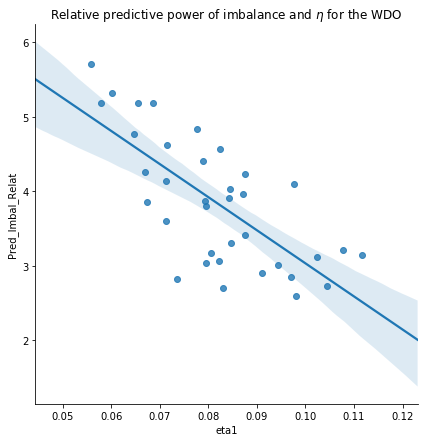

In [37]:
sns.lmplot(x='eta1', y='Pred_Imbal_Relat', data=WDO_IMBAL_TS,\
           aspect=1, height=6);
plt.title('Relative predictive power of imbalance and $\eta$ for the WDO');

In [156]:
ALL_IMBAL_TS = pd.concat([WDO_IMBAL_TS.reset_index(), DOL_IMBAL_TS.reset_index()], sort=False)

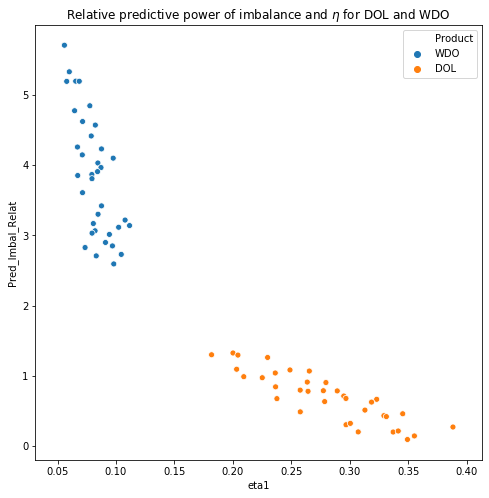

In [157]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x='eta1', y='Pred_Imbal_Relat', hue='Product',\
           data=ALL_IMBAL_TS);
plt.title('Relative predictive power of imbalance and $\eta$ for DOL and WDO');

In [113]:
get_imbal_mat('DOL','2017-01-03')

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask
Trade_Bid,4725,2613,1749,647,2
Imbal_Bid,1635,43989,3138,1529,1287
Neutral,2059,2904,69373,2994,1999
Imbal_Ask,1317,1542,3312,39878,1409
Trade_Ask,0,530,1758,2409,5149


In [112]:
get_imbal_mat('WDO','2017-01-03')

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask
Trade_Bid,36799,12068,8302,4739,423
Imbal_Bid,9426,103967,4482,665,5750
Neutral,9884,2835,99162,2979,9364
Imbal_Ask,5855,647,4583,104565,8621
Trade_Ask,367,4773,7695,11323,34515


In [114]:
perc_mat(get_imbal_mat('DOL','2017-01-03'))

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,2.4,1.3,0.9,0.3,0.0,4.9
Imbal_Bid,0.8,22.2,1.6,0.8,0.7,26.1
Neutral,1.0,1.5,35.0,1.5,1.0,40.1
Imbal_Ask,0.7,0.8,1.7,20.1,0.7,24.0
Trade_Ask,0.0,0.3,0.9,1.2,2.6,5.0
Total Rows,4.9,26.1,40.1,24.0,5.0,100.0


In [115]:
perc_mat(get_imbal_mat('WDO','2017-01-03'))

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,7.5,2.4,1.7,1.0,0.1,12.6
Imbal_Bid,1.9,21.1,0.9,0.1,1.2,25.2
Neutral,2.0,0.6,20.1,0.6,1.9,25.2
Imbal_Ask,1.2,0.1,0.9,21.2,1.7,25.2
Trade_Ask,0.1,1.0,1.6,2.3,7.0,11.9
Total Rows,12.6,25.2,25.2,25.2,11.9,100.0


In [116]:
perc_mat(get_imbal_mat('DOL','2017-01-04'))

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,2.2,1.1,0.7,0.3,0.0,4.3
Imbal_Bid,0.6,22.1,1.4,0.7,0.6,25.5
Neutral,0.8,1.3,35.6,1.4,0.8,40.0
Imbal_Ask,0.6,0.7,1.5,22.7,0.6,26.1
Trade_Ask,0.0,0.3,0.7,1.0,2.1,4.1
Total Rows,4.3,25.5,40.0,26.1,4.1,100.0


In [117]:
perc_mat(get_imbal_mat('WDO','2017-01-04'))

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,7.1,2.5,1.5,0.8,0.1,12.0
Imbal_Bid,1.9,21.8,1.0,0.1,1.1,25.8
Neutral,1.8,0.6,20.9,0.7,1.8,25.9
Imbal_Ask,1.0,0.1,1.0,21.2,1.8,25.0
Trade_Ask,0.1,0.8,1.5,2.3,6.6,11.3
Total Rows,12.0,25.8,25.9,25.0,11.3,100.0


In [139]:
np.round(avg_perc_mat('DOL', IMBAL_DATES),2)

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,2.33,1.19,0.73,0.27,0.00,4.54
Imbal_Bid,0.73,23.47,1.37,0.42,0.55,26.54
Neutral,0.94,1.16,35.25,1.17,0.94,39.44
Imbal_Ask,0.54,0.43,1.36,21.94,0.71,24.98
Trade_Ask,0.00,0.28,0.75,1.18,2.30,4.51
Total Rows,4.54,26.54,39.44,24.97,4.51,100.00


In [140]:
np.round(avg_perc_mat('WDO', IMBAL_DATES),2)

,Trade_Bid,Imbal_Bid,Neutral,Imbal_Ask,Trade_Ask,Total Cols
Trade_Bid,7.15,2.74,1.51,0.85,0.10,12.31
Imbal_Bid,2.13,21.90,0.90,0.12,1.09,26.13
Neutral,1.85,0.55,18.82,0.55,1.80,23.59
Imbal_Ask,1.10,0.11,0.90,21.77,2.09,25.98
Trade_Ask,0.10,0.85,1.47,2.68,6.93,12.00
Total Rows,12.31,26.13,23.59,25.98,12.00,100.00


## States - Depletions and Fills

In [43]:
DF_STATS_DEPL = pd.DataFrame()
for j in range(len(FILESDOL2017)):
    new_row = pd.read_csv(PATHOUT+FILESDOL2017[j][:-4]+'_RDFtrans.csv',\
                         index_col=0, header=[0,1])
    new_row['Dates'] = DATES_DOL[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESDOL2017[j][:3]
    new_row['Contract'] = FILESDOL2017[j][3:6]
    DF_STATS_DEPL = DF_STATS_DEPL.append(new_row)
for j in range(len(FILESWDO2017)):
    new_row = pd.read_csv(PATHOUT+FILESWDO2017[j][:-4]+'_RDFtrans.csv',\
                         index_col=0, header=[0,1])
    new_row['Dates'] = DATES_WDO[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESWDO2017[j][:3]
    new_row['Contract'] = FILESWDO2017[j][3:6]
    DF_STATS_DEPL = DF_STATS_DEPL.append(new_row)
DF_STATS_DEPL.reset_index()
DF_STATS_DEPL.set_index(['Product', 'Contract', 'Dates'], inplace=True)
DF_STATS_DEPL.sort_index(inplace=True)

In [44]:
def get_depl_mat(product, date):
    mat_values = DF_STATS_DEPL.loc[product, :, date].values
    mat_cols = pd.MultiIndex.from_tuples(\
        [('same', ' D C '),\
        ('same', ' D T '),\
        ('same', 'D T+F'),\
        ('same', '  F  '),\
        ('oppo', ' D C '),\
        ('oppo', ' D T '),\
        ('oppo', 'D T+F'),\
        ('oppo', '  F  ')])
    mat_df = pd.DataFrame(mat_values,\
        columns=mat_cols,\
        index=[' D C ', ' D T ',\
            'D T+F', '  F  '])
    return mat_df

In [74]:
def summ_depl(mat):
    depl_c = mat.loc[' D C ']['Total Cols'].sum()
    depl_t = mat.loc[' D T ']['Total Cols'].sum()
    depl_tf = mat.loc['D T+F']['Total Cols'].sum()
    depl_c_s = mat.loc[' D C ']['same', '  F  ']-mat.loc[' D C ']['oppo', '  F  ']
    depl_t_s = mat.loc[' D T ']['same', '  F  ']-mat.loc[' D T ']['oppo', '  F  ']
    depl_tf_s = mat.loc['D T+F']['same', '  F  ']-mat.loc['D T+F']['oppo', '  F  ']
    depl_f_s = mat.loc['  F  ']['same'].sum()-mat.loc['  F  ']['oppo'].sum()
    return [depl_c, depl_t, depl_tf, depl_c_s, depl_t_s, depl_tf_s, depl_f_s]

In [80]:
def time_series_depl(product, dates):
    list_depl = []
    for date in dates:
        new_mat = perc_mat(get_depl_mat(product, date))
        new_row = summ_depl(new_mat)
        list_depl = list_depl+[new_row]
    df_depl = pd.DataFrame(list_depl, columns=['Depl_Cancel', 'Depl_Trade',\
        'Depl_Trade+Fill', 'DC same-oppo', 'DT same-oppo', 'DT+F same-oppo',\
        'Fill same-oppo'], index=dates)
    return df_depl

In [45]:
def avg_perc_mat_2(product, dates):
    date_count = 1
    result = perc_mat(get_depl_mat(product, dates[date_count-1]))
    for date in dates[1:]:
        date_count += 1
        result += (perc_mat(get_depl_mat(product, dates[date_count-1]))-result)/date_count
    return result

In [47]:
get_depl_mat('DOL', '2017-01-03')

same                    oppo                  
       D C   D T  D T+F   F    D C   D T  D T+F   F  
 D C      4     4    73  2283     3     3   105   225
 D T      9    62   168  1541    14    14   708   492
D T+F    59    60    99   594    23    21   208   297
  F    2000  1252     0    24   588  1593     0   101

In [131]:
get_depl_mat('WDO', '2017-01-03')

same                    oppo                  
       D C   D T  D T+F   F    D C   D T  D T+F   F  
 D C      0     0     3  1986     0     2   286    36
 D T      3    46   126  4240     1     6   836   920
D T+F     1     8    32  1030     0     3   227   211
  F    1200  2264     1    19  1108  3850     1    23

In [48]:
perc_mat(get_depl_mat('DOL', '2017-01-03'))

same                                      oppo             \
                 D C        D T      D T+F        F        D C        D T    
 D C         0.031678   0.031678  0.578126  18.080304  0.023759   0.023759   
 D T         0.071276   0.491011  1.330482  12.204007  0.110874   0.110874   
D T+F        0.467253   0.475172  0.784034   4.704205  0.182149   0.166310   
  F         15.839075   9.915261  0.000000   0.190069  4.656688  12.615823   
Total Rows  16.409282  10.913123  2.692643  35.178586  4.973470  12.916766   

                                Total Cols  
               D T+F       F                
 D C        0.831551  1.781896   21.382751  
 D T        5.607033  3.896412   23.821969  
D T+F       1.647264  2.352103   10.778491  
  F         0.000000  0.799873   44.016789  
Total Rows  8.085848  8.830284  100.000000

In [114]:
DOL_DEPL_TS = time_series_depl('DOL', IMBAL_DATES)

In [115]:
DOL_DEPL_TS['eta1'] = DOL_ETA
DOL_DEPL_TS['Product'] = 'DOL'
DOL_DEPL_TS.index.names=['Dates']

In [116]:
WDO_DEPL_TS = time_series_depl('WDO', IMBAL_DATES)

In [117]:
WDO_DEPL_TS['eta1'] = WDO_ETA
WDO_DEPL_TS['Product'] = 'WDO'
WDO_DEPL_TS.index.names=['Dates']

In [174]:
ALL_DEPL_TS = pd.concat([WDO_DEPL_TS.reset_index(), DOL_DEPL_TS.reset_index()], sort=False)

In [136]:
DOL_DEPL_TS_MI = DOL_DEPL_TS.copy().drop(columns=['Product'])
DOL_DEPL_TS_MI.columns = pd.MultiIndex.from_product([['DOL'], DOL_DEPL_TS_MI.columns], names=['Product', 'Event'])

In [137]:
WDO_DEPL_TS_MI = WDO_DEPL_TS.copy().drop(columns=['Product'])
WDO_DEPL_TS_MI.columns = pd.MultiIndex.from_product([['WDO'], WDO_DEPL_TS_MI.columns], names=['Product', 'Event'])

In [158]:
ALL_DEPL_TS_MI = pd.concat([WDO_DEPL_TS_MI, DOL_DEPL_TS_MI], axis=1)

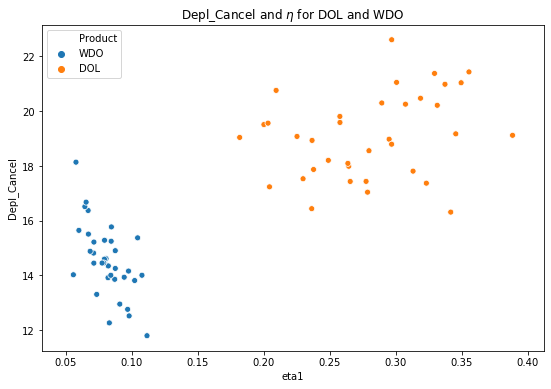

In [175]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x='eta1', y='Depl_Cancel', hue='Product',\
           data=ALL_DEPL_TS);
plt.title('Depl_Cancel and $\eta$ for DOL and WDO');

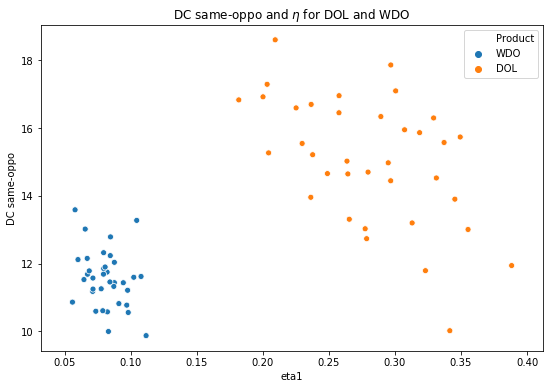

In [176]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x='eta1', y='DC same-oppo', hue='Product',\
           data=ALL_DEPL_TS);
plt.title('DC same-oppo and $\eta$ for DOL and WDO');

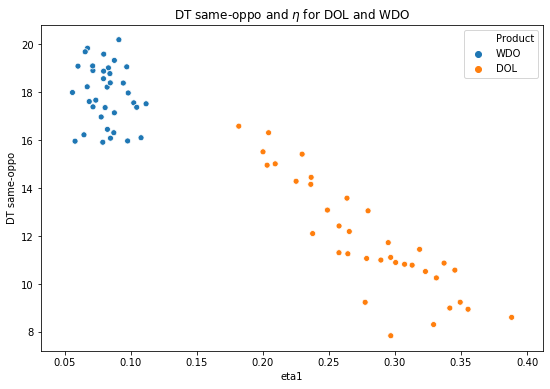

In [177]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x='eta1', y='DT same-oppo', hue='Product',\
           data=ALL_DEPL_TS);
plt.title('DT same-oppo and $\eta$ for DOL and WDO');

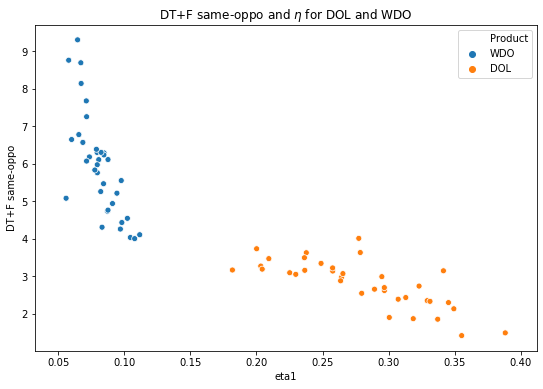

In [178]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x='eta1', y='DT+F same-oppo', hue='Product',\
           data=ALL_DEPL_TS);
plt.title('DT+F same-oppo and $\eta$ for DOL and WDO');

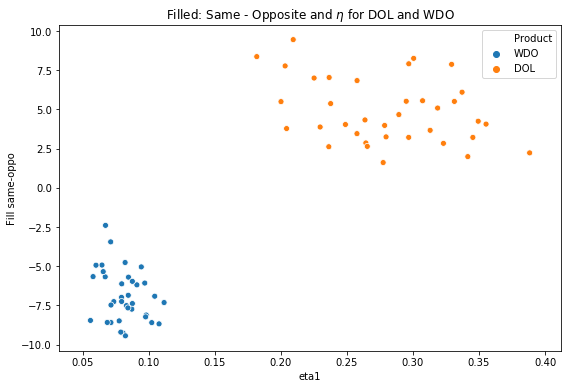

In [179]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x='eta1', y='Fill same-oppo', hue='Product',\
           data=ALL_DEPL_TS);
plt.title('Filled: Same - Opposite and $\eta$ for DOL and WDO');

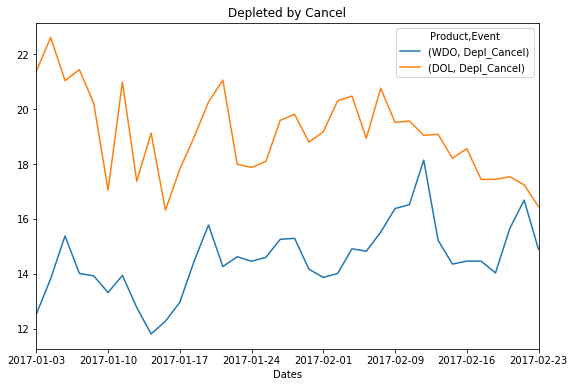

In [165]:
ALL_DEPL_TS_MI.loc[slice(None),(slice(None),'Depl_Cancel')]\
    .plot(figsize=(9, 6), title='Depleted by Cancel');

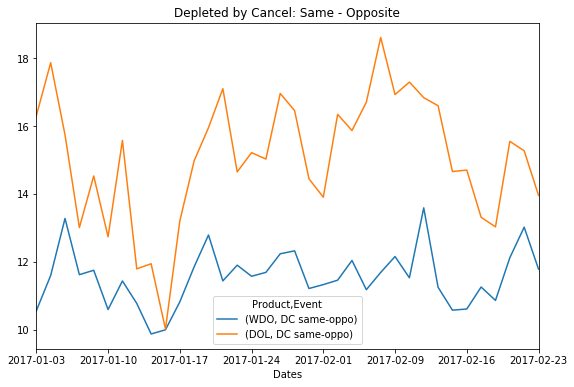

In [166]:
ALL_DEPL_TS_MI.loc[slice(None),(slice(None),'DC same-oppo')]\
    .plot(figsize=(9, 6), title='Depleted by Cancel: Same - Opposite');

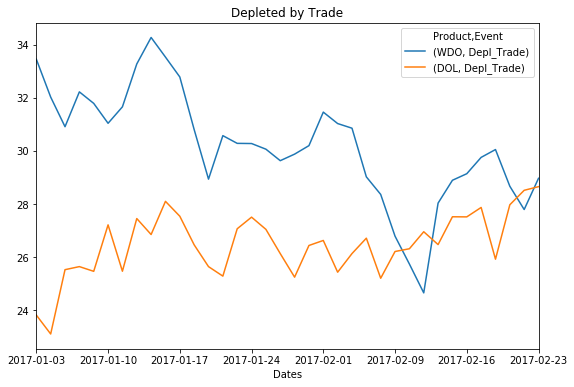

In [167]:
ALL_DEPL_TS_MI.loc[slice(None),(slice(None),'Depl_Trade')]\
    .plot(figsize=(9, 6), title='Depleted by Trade');

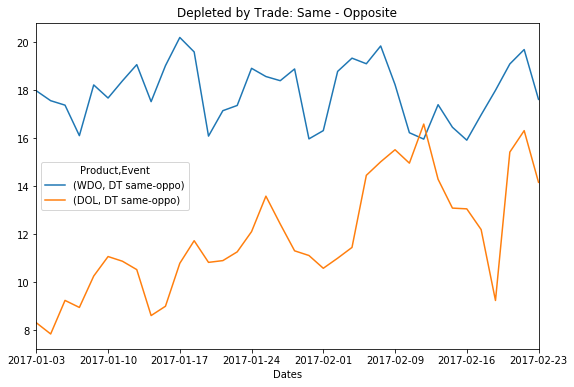

In [168]:
ALL_DEPL_TS_MI.loc[slice(None),(slice(None),'DT same-oppo')]\
    .plot(figsize=(9, 6), title='Depleted by Trade: Same - Opposite');

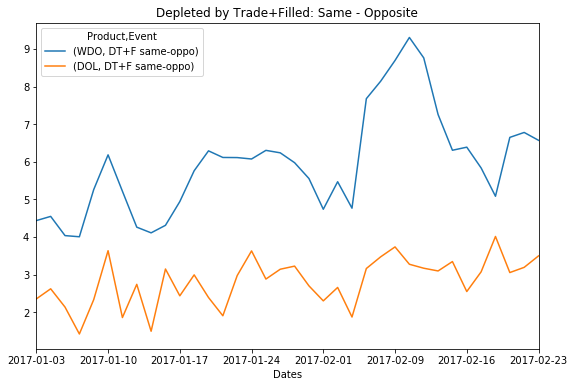

In [169]:
ALL_DEPL_TS_MI.loc[slice(None),(slice(None),'DT+F same-oppo')]\
    .plot(figsize=(9, 6), title='Depleted by Trade+Filled: Same - Opposite');

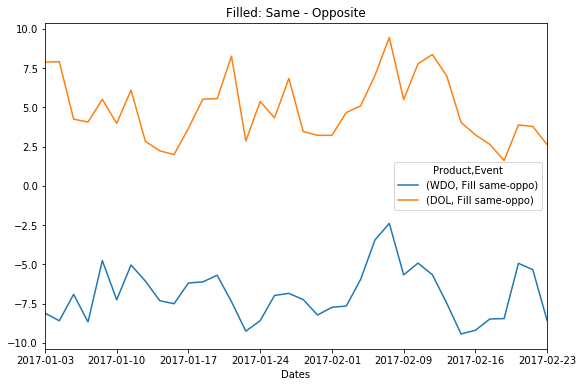

In [170]:
ALL_DEPL_TS_MI.loc[slice(None),(slice(None),'Fill same-oppo')]\
    .plot(figsize=(9, 6), title='Filled: Same - Opposite');

In [133]:
perc_mat(get_depl_mat('WDO', '2017-01-03'))

same                    oppo                   Total Cols
            D C   D T  D T+F   F    D C   D T  D T+F   F             
 D C         0.0   0.0   0.0  10.8   0.0   0.0   1.5   0.2       12.5
 D T         0.0   0.2   0.7  23.0   0.0   0.0   4.5   5.0       33.5
D T+F        0.0   0.0   0.2   5.6   0.0   0.0   1.2   1.1        8.2
  F          6.5  12.3   0.0   0.1   6.0  20.8   0.0   0.1       45.8
Total Rows   6.5  12.6   0.9  39.4   6.0  20.9   7.3   6.4      100.0

In [134]:
perc_mat(get_depl_mat('DOL', '2017-01-04'))

same                    oppo                   Total Cols
            D C   D T  D T+F   F    D C   D T  D T+F   F             
 D C         0.0   0.0   0.3  19.5   0.0   0.0   1.0   1.7       22.6
 D T         0.0   0.6   1.2  11.9   0.2   0.1   5.1   4.1       23.1
D T+F        0.4   0.4   0.8   4.6   0.1   0.1   1.2   2.0        9.6
  F         16.7   9.4   0.0   0.2   5.2  12.5   0.0   0.7       44.7
Total Rows  17.1  10.4   2.3  36.3   5.5  12.7   7.3   8.4      100.0

In [135]:
perc_mat(get_depl_mat('WDO', '2017-01-04'))

same                    oppo                   Total Cols
            D C   D T  D T+F   F    D C   D T  D T+F   F             
 D C         0.0   0.0   0.0  11.8   0.0   0.0   1.8   0.2       13.8
 D T         0.0   0.1   0.7  22.1   0.0   0.0   4.4   4.6       32.0
D T+F        0.0   0.1   0.2   5.7   0.0   0.0   1.3   1.1        8.5
  F          7.0  11.5   0.0   0.1   6.8  20.2   0.0   0.1       45.7
Total Rows   7.0  11.7   1.0  39.7   6.8  20.3   7.5   6.0      100.0

In [141]:
np.round(avg_perc_mat_2('DOL', IMBAL_DATES),2)

same                      oppo                    Total Cols
             D C    D T  D T+F    F    D C    D T  D T+F   F             
 D C         0.01   0.02  0.30  16.42  0.02   0.01  0.95  1.33      19.09
 D T         0.06   0.44  1.13  15.61  0.12   0.09  5.33  3.72      26.47
D T+F        0.32   0.32  0.74   4.84  0.13   0.11  1.28  2.01       9.72
  F         13.13  11.49  0.00   0.18  5.31  13.99  0.00  0.61      44.71
Total Rows  13.53  12.28  2.16  37.03  5.57  14.20  7.55  7.68     100.00

In [142]:
np.round(avg_perc_mat_2('WDO', IMBAL_DATES),2)

same                      oppo                    Total Cols
            D C    D T  D T+F    F    D C    D T  D T+F   F             
 D C        0.00   0.00  0.00  11.68  0.00   0.00  2.67  0.12      14.54
 D T        0.00   0.15  0.55  21.17  0.01   0.01  4.99  3.26      30.20
D T+F       0.00   0.01  0.26   7.09  0.00   0.00  2.11  1.13      10.64
  F         7.27  11.53  0.00   0.07  7.22  18.44  0.00  0.11      44.64
Total Rows  7.29  11.71  0.84  40.01  7.25  18.49  9.79  4.63     100.00

In [144]:
np.round(avg_perc_mat_2('DOL', IMBAL_DATES),0)

same                    oppo                   Total Cols
            D C   D T  D T+F   F    D C   D T  D T+F   F             
 D C         0.0   0.0   0.0  16.0   0.0   0.0   1.0   1.0       19.0
 D T         0.0   0.0   1.0  16.0   0.0   0.0   5.0   4.0       26.0
D T+F        0.0   0.0   1.0   5.0   0.0   0.0   1.0   2.0       10.0
  F         13.0  11.0   0.0   0.0   5.0  14.0   0.0   1.0       45.0
Total Rows  14.0  12.0   2.0  37.0   6.0  14.0   8.0   8.0      100.0

In [143]:
np.round(avg_perc_mat_2('WDO', IMBAL_DATES),0)

same                    oppo                   Total Cols
            D C   D T  D T+F   F    D C   D T  D T+F   F             
 D C         0.0   0.0   0.0  12.0   0.0   0.0   3.0   0.0       15.0
 D T         0.0   0.0   1.0  21.0   0.0   0.0   5.0   3.0       30.0
D T+F        0.0   0.0   0.0   7.0   0.0   0.0   2.0   1.0       11.0
  F          7.0  12.0   0.0   0.0   7.0  18.0   0.0   0.0       45.0
Total Rows   7.0  12.0   1.0  40.0   7.0  18.0  10.0   5.0      100.0

## Dataframe of price changes by k

In [43]:
DF_STATS_MOVES = pd.DataFrame()
for j in range(len(FILESDOL2017)):
    new_row = pd.read_hdf(PATHOUT+FILESDOL2017[j][:-4]+'_CAticks.h5')
    new_row['Dates'] = DATES_DOL[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESDOL2017[j][:3]
    new_row['Contract'] = FILESDOL2017[j][3:6]
    DF_STATS_MOVES = DF_STATS_MOVES.append(new_row)
for j in range(len(FILESWDO2017)):
    new_row = pd.read_hdf(PATHOUT+FILESWDO2017[j][:-4]+'_CAticks.h5')
    new_row['Dates'] = DATES_WDO[j].strftime('%Y-%m-%d')
    new_row['Product'] = FILESWDO2017[j][:3]
    new_row['Contract'] = FILESWDO2017[j][3:6]
    DF_STATS_MOVES = DF_STATS_MOVES.append(new_row)
DF_STATS_MOVES.reset_index()
DF_STATS_MOVES.set_index(['Product', 'Contract', 'Dates'], inplace=True)
DF_STATS_MOVES.sort_index(inplace=True)

In [44]:
def get_moves_mat(product, contract, date):
    mat_values = DF_STATS_MOVES.loc[product, contract, date].values
    mat_df = pd.DataFrame(mat_values,\
        columns=['Move in ticks', 'lambda',\
            'Continuations', 'Alternations', 'u', 'eta'],)
    return mat_df

In [45]:
def get_lambda1_mat():
    sub_mat = DF_STATS_MOVES.copy().reset_index()
    sub_mat = sub_mat[sub_mat['Li']==1]\
        [['Product', 'Contract', 'Dates', 'lamb']]
    return sub_mat

In [46]:
get_moves_mat('DOL','G17','2017-01-03')

,Move in ticks,lambda,Continuations,Alternations,u,eta
0,1.0,0.966530,1240.0,1820.0,0.340659,0.329257
1,2.0,0.032523,18.0,85.0,-0.288235,-0.009374
2,3.0,0.000947,0.0,3.0,-1.000000,-0.000947


In [47]:
get_moves_mat('WDO','G17','2017-01-03')

,Move in ticks,lambda,Continuations,Alternations,u,eta
0,1.0,0.986951,2358.0,11861.0,0.099401,0.098104
1,2.0,0.011245,5.0,157.0,-0.468153,-0.005264
2,3.0,0.000555,0.0,7.0,-1.000000,-0.000555
3,4.0,0.000416,0.0,6.0,-1.500000,-0.000625
4,5.0,0.000278,1.0,3.0,-1.166667,-0.000324
5,6.0,0.000347,0.0,5.0,-2.500000,-0.000868
6,7.0,0.000069,0.0,1.0,-3.000000,-0.000208
7,8.0,0.000069,0.0,1.0,-3.500000,-0.000243
8,9.0,0.000069,0.0,1.0,-4.000000,-0.000278


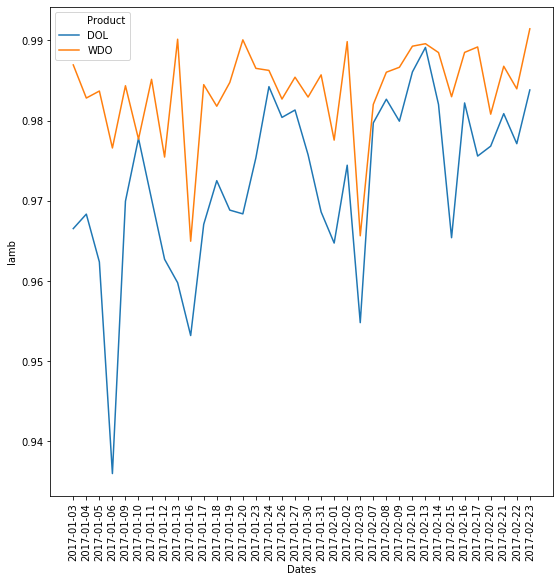

In [48]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='lamb', hue='Product', data=get_lambda1_mat());
plt.xticks(rotation=90);

In [49]:
#DOL_MEAN_COST[DOL_MEAN_COST['Trade Qty']<=300].plot.scatter(x='Trade Qty', y='Avg_Cost');